In [1]:
!pip install torchinfo
!nvidia-smi

Wed Aug  7 14:19:00 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8               8W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [14]:
# import

import numpy as np
from datetime import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, ConcatDataset
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import torchinfo
import os
from pytz import timezone
from tqdm import tqdm

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "0,1"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', DEVICE)  # 출력결과: cuda
print('Count of using GPUs:', torch.cuda.device_count())
print('Current cuda device:', torch.cuda.current_device())

Device: cuda
Count of using GPUs: 1
Current cuda device: 0


In [15]:
## 하이퍼파라미터 설정
RANDOM_SEED = 4242
LEARNING_RATE = 0.01
MOMENTUM = 0.9
WEIGHT_DECAY = 5e-4
BATCH_SIZE = 128
EPOCHS = 40
IMG_SIZE = 32
NUM_CLASSES = 10

# 규제화 파라미터 설정
DROPOUT = 0.5

In [16]:
# 모델의 정확도를 계산하는 함수
def get_accuracy(model, data_loader, device):
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
        model.eval()
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            probabilities = F.softmax(model(images), dim=-1)
            _, predicted_labels = torch.max(probabilities, 1)

            total_predictions += labels.size(0)
            correct_predictions += (predicted_labels == labels).sum()
    return correct_predictions.float() / total_predictions

In [17]:
# 학습 손실과 검증 손실을 시각화
def plot_loss(train_loss, val_loss):
    plt.style.use("grayscale")
    train_loss = np.array(train_loss)
    val_loss = np.array(val_loss)
    fig, ax = plt.subplots(1, 1, figsize=(8, 4.5))
    ax.plot(train_loss, color="green", label="Training Loss")
    ax.plot(val_loss, color="red", label="Validation Loss")
    ax.set(title="Loss Over Epochs", xlabel="EPOCH", ylabel="LOSS")
    ax.legend()
    fig.show()
    plt.style.use("default")

In [18]:
# 모델 학습 함수
def train(train_loader, model, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        images = images.to(device)
        labels = labels.to(device)
        logits = model(images)
        loss = criterion(logits, labels)
        total_loss += loss.item() * images.size(0)
        loss.backward()
        optimizer.step()
    epoch_loss = total_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

In [19]:
# 검증 데이터셋을 사용하여 모델의 성능을 평가
def validate(valid_loader, model, criterion, device):
    model.eval()
    total_loss = 0

    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)

        # 순전파와 손실 기록하기
        logits = model(images)
        loss = criterion(logits, labels)
        total_loss += loss.item() * images.size(0)

    epoch_loss = total_loss / len(valid_loader.dataset)
    return model, epoch_loss

In [20]:
def training_loop(
    model,
    criterion,
    optimizer,
    lr_scheduler,
    train_loader,
    valid_loader,
    epochs,
    device,
    print_every=1,
):
    train_losses = []
    valid_losses = []
    print(
        datetime.now(timezone("Asia/Seoul")).time().replace(microsecond=0),
        "--- Start Training Loop ---",
    )

    for epoch in range(epochs):
        # training
        model.train()
        running_loss = 0.0
        train_loader_tqdm = tqdm(
            train_loader, desc=f"Epoch {epoch + 1}/{epochs}", leave=False
        )
        for inputs, labels in train_loader_tqdm:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        # validation
        model.eval()
        running_loss = 0.0
        valid_loader_tqdm = tqdm(
            valid_loader, desc=f"Validation {epoch + 1}/{epochs}", leave=False
        )
        with torch.no_grad():
            for inputs, labels in valid_loader_tqdm:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)

        valid_loss = running_loss / len(valid_loader.dataset)
        valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):

            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)

            print(
                datetime.now(timezone("Asia/Seoul")).time().replace(microsecond=0),
                "--- ",
                f"Epoch: {epoch + 1}\t"
                f"Train loss: {train_loss:.4f}\t"
                f"Valid loss: {valid_loss:.4f}\t"
                f"Train accuracy: {100 * train_acc:.2f}\t"
                f"Valid accuracy: {100 * valid_acc:.2f}",
            )

        lr_scheduler.step(valid_acc)

    plot_loss(train_losses, valid_losses)

    return model, optimizer, (train_losses, valid_losses)

In [21]:
# VGGNet16 모델의 Block 정의
class VGGNet16Block(nn.Module):
    def __init__(self, in_channels, out_channels, num_convs):
        super(VGGNet16Block, self).__init__()
        self.convs = nn.ModuleList(
            [
                nn.Conv2d(
                    in_channels if i == 0 else out_channels,
                    out_channels,
                    kernel_size=3,
                    padding=1,
                )
                for i in range(num_convs)
            ]
        )
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        for conv in self.convs:
            x = F.relu(conv(x))
        x = self.batchnorm(x)
        x = -self.pool(-x)
        return x


# VGGNet16 모델 정의
class MiniVGGNet16(nn.Module):
    def __init__(self):
        super(MiniVGGNet16, self).__init__()
        self.dropout = nn.Dropout(DROPOUT)

        self.block1 = VGGNet16Block(3, 64, num_convs=2)
        self.block2 = VGGNet16Block(64, 128, num_convs=2)
        self.block3 = VGGNet16Block(128, 256, num_convs=3)
        self.block4 = VGGNet16Block(256, 512, num_convs=3)
        self.block5 = VGGNet16Block(512, 512, num_convs=3)

        self.fc14 = nn.Linear(512, 1024)
        self.fc15 = nn.Linear(1024, 1024)
        self.fc16 = nn.Linear(1024, NUM_CLASSES)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)

        x = x.view(-1, 512)
        x = F.relu(self.fc14(x))
        x = self.dropout(x)
        x = F.relu(self.fc15(x))
        x = self.dropout(x)
        logits = self.fc16(x)

        return logits


torchinfo.summary(
    MiniVGGNet16(),
    input_size=(1, 3, IMG_SIZE, IMG_SIZE),
    col_names=["input_size", "output_size", "num_params", "kernel_size"],
    row_settings=["depth", "var_names"],
)

Layer (type (var_name):depth-idx)        Input Shape               Output Shape              Param #                   Kernel Shape
MiniVGGNet16 (MiniVGGNet16)              [1, 3, 32, 32]            [1, 10]                   --                        --
├─VGGNet16Block (block1): 1-1            [1, 3, 32, 32]            [1, 64, 16, 16]           --                        --
│    └─ModuleList (convs): 2-1           --                        --                        --                        --
│    │    └─Conv2d (0): 3-1              [1, 3, 32, 32]            [1, 64, 32, 32]           1,792                     [3, 3]
│    │    └─Conv2d (1): 3-2              [1, 64, 32, 32]           [1, 64, 32, 32]           36,928                    [3, 3]
│    └─BatchNorm2d (batchnorm): 2-2      [1, 64, 32, 32]           [1, 64, 32, 32]           128                       --
│    └─MaxPool2d (pool): 2-3             [1, 64, 32, 32]           [1, 64, 16, 16]           --                        2
├─VGGNe

Files already downloaded and verified


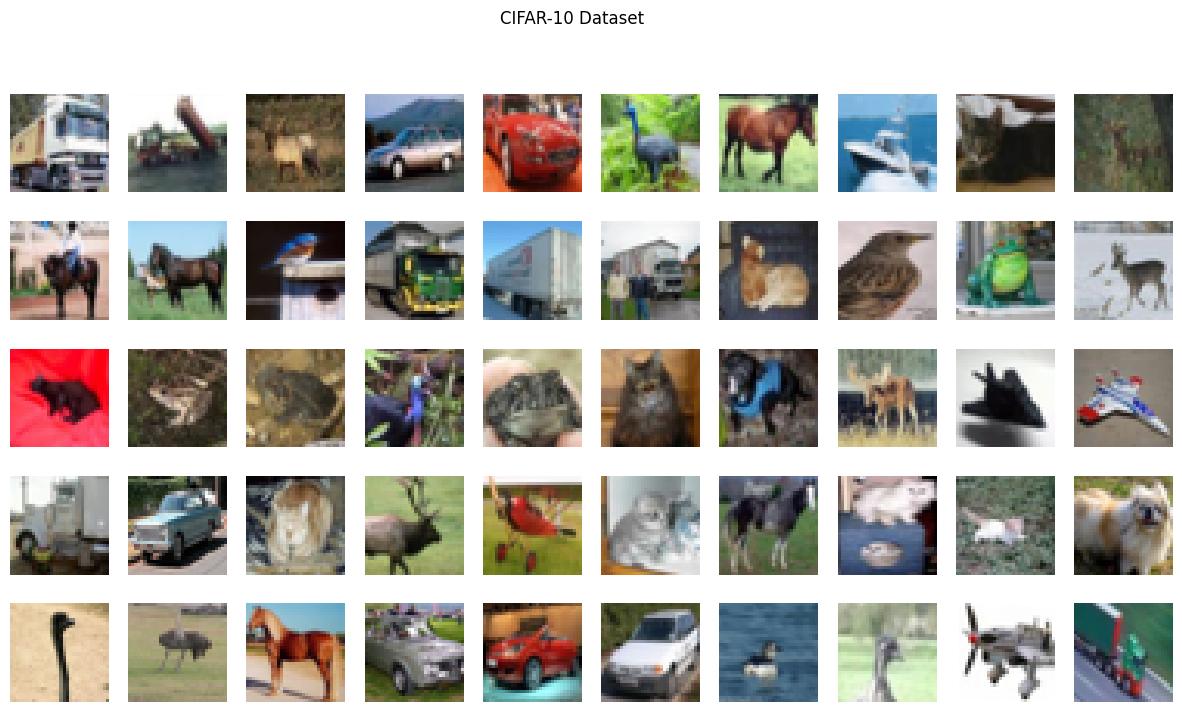

train dataset size:  40000
valid dataset size:  10000
test dataset size:  10000


In [22]:
transform = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),  # 50% 확률로 수평 뒤집기
        transforms.ToTensor(),
    ]
)

# 데이터셋 다운로드 및 생성
full_dataset = datasets.CIFAR10(root="cifar10_data", train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root="cifar10_data", train=False, transform=transform)

test_size = len(test_dataset)
valid_size = test_size
train_size = len(full_dataset) - valid_size

train_dataset, valid_dataset = random_split(full_dataset, [train_size, valid_size])

# 데이터 로더 정의
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# 불러온 CIFAR-10 데이터 확인
ROW_IMG = 10
N_ROWS = 5

fig = plt.figure(figsize=(15, 8))
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis("off")
    img = train_dataset.dataset[index][0]
    img = img.permute(1, 2, 0)  # (채널, 높이, 너비) -> (높이, 너비, 채널)
    plt.imshow(img)

fig.suptitle("CIFAR-10 Dataset")
plt.show()

# 데이터셋 크기 출력
print("train dataset size: ", len(train_dataset))
print("valid dataset size: ", len(valid_dataset))
print("test dataset size: ", len(test_dataset))


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


23:52:19 --- Start Training Loop ---


23:52:51 ---  Epoch: 1	Train loss: 1.8176	Valid loss: 1.5738	Train accuracy: 39.10	Valid accuracy: 39.43


23:53:24 ---  Epoch: 2	Train loss: 1.3227	Valid loss: 1.9829	Train accuracy: 41.44	Valid accuracy: 40.42


23:53:56 ---  Epoch: 3	Train loss: 1.0254	Valid loss: 1.7009	Train accuracy: 50.15	Valid accuracy: 48.70


23:54:29 ---  Epoch: 4	Train loss: 0.8607	Valid loss: 0.9739	Train accuracy: 68.57	Valid accuracy: 67.25


23:55:02 ---  Epoch: 5	Train loss: 0.7546	Valid loss: 0.9563	Train accuracy: 69.61	Valid accuracy: 67.03


23:55:34 ---  Epoch: 6	Train loss: 0.6723	Valid loss: 0.9023	Train accuracy: 73.26	Valid accuracy: 70.62


23:56:07 ---  Epoch: 7	Train loss: 0.6114	Valid loss: 1.0167	Train accuracy: 70.51	Valid accuracy: 67.41


23:56:40 ---  Epoch: 8	Train loss: 0.5506	Valid loss: 0.9872	Train accuracy: 74.39	Valid accuracy: 70.93


23:57:13 ---  Epoch: 9	Train loss: 0.5023	Valid loss: 0.7173	Train accuracy: 81.66	Valid accuracy: 77.00


23:57:45 ---  Epoch: 10	Train loss: 0.4662	Valid loss: 0.6977	Train accuracy: 82.93	Valid accuracy: 76.65


23:58:18 ---  Epoch: 11	Train loss: 0.4212	Valid loss: 0.6679	Train accuracy: 85.14	Valid accuracy: 78.38


23:58:50 ---  Epoch: 12	Train loss: 0.3859	Valid loss: 0.6955	Train accuracy: 85.17	Valid accuracy: 78.09


23:59:23 ---  Epoch: 13	Train loss: 0.3613	Valid loss: 0.6114	Train accuracy: 88.47	Valid accuracy: 81.30


23:59:55 ---  Epoch: 14	Train loss: 0.3303	Valid loss: 0.7224	Train accuracy: 84.91	Valid accuracy: 77.37


00:00:28 ---  Epoch: 15	Train loss: 0.2985	Valid loss: 0.6944	Train accuracy: 87.32	Valid accuracy: 79.54


00:01:01 ---  Epoch: 16	Train loss: 0.2769	Valid loss: 0.6002	Train accuracy: 92.13	Valid accuracy: 82.25


00:01:34 ---  Epoch: 17	Train loss: 0.2558	Valid loss: 0.6795	Train accuracy: 88.70	Valid accuracy: 80.46


00:02:06 ---  Epoch: 18	Train loss: 0.2455	Valid loss: 0.7001	Train accuracy: 89.59	Valid accuracy: 80.40


00:02:40 ---  Epoch: 19	Train loss: 0.2238	Valid loss: 0.6377	Train accuracy: 92.19	Valid accuracy: 81.90


00:03:12 ---  Epoch: 20	Train loss: 0.2144	Valid loss: 0.6585	Train accuracy: 91.53	Valid accuracy: 81.61


00:03:45 ---  Epoch: 21	Train loss: 0.1104	Valid loss: 0.4822	Train accuracy: 98.04	Valid accuracy: 86.28


00:04:18 ---  Epoch: 22	Train loss: 0.0740	Valid loss: 0.5065	Train accuracy: 98.58	Valid accuracy: 86.22


00:04:51 ---  Epoch: 23	Train loss: 0.0582	Valid loss: 0.5279	Train accuracy: 98.95	Valid accuracy: 86.36


00:05:24 ---  Epoch: 24	Train loss: 0.0457	Valid loss: 0.5493	Train accuracy: 99.25	Valid accuracy: 86.71


00:05:58 ---  Epoch: 25	Train loss: 0.0351	Valid loss: 0.5698	Train accuracy: 99.43	Valid accuracy: 86.65


00:06:30 ---  Epoch: 26	Train loss: 0.0292	Valid loss: 0.5819	Train accuracy: 99.61	Valid accuracy: 86.37


00:07:03 ---  Epoch: 27	Train loss: 0.0225	Valid loss: 0.6004	Train accuracy: 99.68	Valid accuracy: 86.60


00:07:36 ---  Epoch: 28	Train loss: 0.0182	Valid loss: 0.6122	Train accuracy: 99.77	Valid accuracy: 86.53


00:08:09 ---  Epoch: 29	Train loss: 0.0155	Valid loss: 0.6128	Train accuracy: 99.76	Valid accuracy: 86.41


00:08:42 ---  Epoch: 30	Train loss: 0.0151	Valid loss: 0.6233	Train accuracy: 99.81	Valid accuracy: 86.56


00:09:15 ---  Epoch: 31	Train loss: 0.0142	Valid loss: 0.6290	Train accuracy: 99.80	Valid accuracy: 86.49


00:09:48 ---  Epoch: 32	Train loss: 0.0139	Valid loss: 0.6221	Train accuracy: 99.82	Valid accuracy: 86.55


00:10:22 ---  Epoch: 33	Train loss: 0.0136	Valid loss: 0.6343	Train accuracy: 99.80	Valid accuracy: 86.76


00:10:54 ---  Epoch: 34	Train loss: 0.0138	Valid loss: 0.6317	Train accuracy: 99.81	Valid accuracy: 86.56


00:11:27 ---  Epoch: 35	Train loss: 0.0127	Valid loss: 0.6357	Train accuracy: 99.82	Valid accuracy: 86.49


00:12:00 ---  Epoch: 36	Train loss: 0.0141	Valid loss: 0.6220	Train accuracy: 99.81	Valid accuracy: 86.41


00:12:33 ---  Epoch: 37	Train loss: 0.0135	Valid loss: 0.6242	Train accuracy: 99.81	Valid accuracy: 86.57


00:13:06 ---  Epoch: 38	Train loss: 0.0127	Valid loss: 0.6239	Train accuracy: 99.83	Valid accuracy: 86.38


00:13:40 ---  Epoch: 39	Train loss: 0.0135	Valid loss: 0.6248	Train accuracy: 99.82	Valid accuracy: 86.56


00:14:12 ---  Epoch: 40	Train loss: 0.0128	Valid loss: 0.6213	Train accuracy: 99.78	Valid accuracy: 86.59


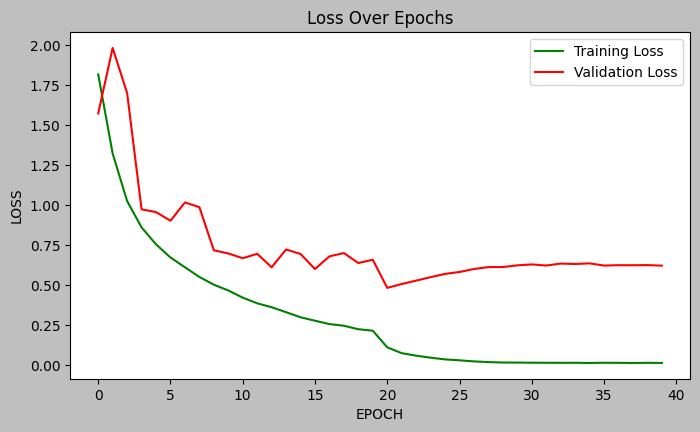

In [23]:
torch.manual_seed(RANDOM_SEED)

_model = MiniVGGNet16().cuda()
model = nn.DataParallel(_model).to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY, nesterov=True)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True)

criterion = nn.CrossEntropyLoss()

model, optimizer, _ = training_loop(
    model, criterion, optimizer, lr_scheduler, train_loader, valid_loader, EPOCHS, DEVICE
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Test Loss: 0.6332, Test Accuracy: 0.8647


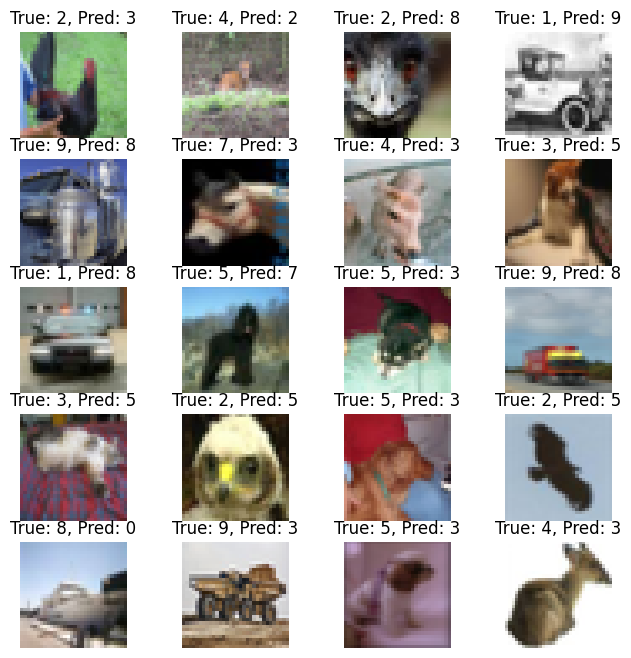

In [24]:
import matplotlib.pyplot as plt

# 테스트 데이터셋을 사용하여 모델의 성능을 평가하고 틀린 예시를 저장
def test_and_collect_mistakes(test_loader, model, criterion, device):
    model.eval()  # 평가 모드로 전환
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    mistakes = []

    with torch.no_grad():  # 평가시에는 그래디언트 계산 불필요
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            # 순전파와 손실 기록하기
            logits = model(images)
            loss = criterion(logits, labels)
            total_loss += loss.item() * images.size(0)

            # 예측 및 정확도 계산
            _, preds = torch.max(logits, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # 틀린 예시 저장
            for i in range(len(labels)):
                if preds[i] != labels[i]:
                    mistakes.append((images[i].cpu(), labels[i].cpu(), preds[i].cpu()))

    epoch_loss = total_loss / len(test_loader.dataset)
    accuracy = correct / total

    print(f"Test Loss: {epoch_loss:.4f}, Test Accuracy: {accuracy:.4f}")
    return epoch_loss, accuracy, all_preds, all_labels, mistakes

# 모델 학습이 완료된 후 평가 수행
test_loss, test_accuracy, test_preds, test_labels, mistakes = test_and_collect_mistakes(test_loader, model, criterion, DEVICE)

# 틀린 예시 시각화
def plot_mistakes(mistakes, num_examples=20):
    plt.figure(figsize=(8, 8))
    for i, (image, true_label, pred_label) in enumerate(mistakes[:num_examples]):
        plt.subplot(5, 4, i + 1)
        plt.axis('off')
        image = image.permute(1, 2, 0)
        plt.imshow(image)
        plt.title(f'True: {true_label}, Pred: {pred_label}')
    plt.show()

# 틀린 예시 출력
plot_mistakes(mistakes)
